# Residual Networks

In theory, very deep networks can represent very complex functions; but in practice, they are hard to train. Residual Networks, introduced by [He et al.](https://arxiv.org/pdf/1512.03385.pdf), allow you to train much deeper networks than were previously practically feasible.

In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydotplus
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

## 1 - The problem of very deep neural networks

The main benefit of a very deep network is that it can represent very complex functions. It can also learn features at many different levels of abstraction, from edges (at the lower layers) to very complex features (at the deeper layers). However, using a deeper network doesn't always help. A huge barrier to training them is **vanishing gradients**: very deep networks often have a gradient signal that goes to zero quickly, thus making gradient descent unbearably slow. More specifically, during gradient descent, as you backprop from the final layer back to the first layer, you are multiplying by the weight matrix on each step, and thus the gradient can decrease exponentially quickly to zero (or, in rare cases, grow exponentially quickly and "explode" to take very large values). 

During training, you might therefore see the magnitude (or norm) of the gradient for the earlier layers descrease to zero very rapidly as training proceeds: 

<img src="images/vanishing_grad_kiank.png" style="width:450px;height:220px;">
<caption><center> <u> <font color='purple'> Figure 1 </u><font color='purple'>  : Vanishing gradient <br> The speed of learning decreases very rapidly for the early layers as the network trains </center></caption>

You are now going to solve this problem by building a Residual Network!
<br><br>   
## 2 - Building a Residual Network

In ResNets, a "shortcut" or a "skip connection" allows the gradient to be directly backpropagated to earlier layers:  

<img src="images/skip_connection_kiank.png" style="width:650px;height:200px;">
<caption><center> <u> <font color='purple'> **Figure 2** </u><font color='purple'>  : A ResNet block showing a **skip-connection** <br> </center></caption>

The image on the left shows the "main path" through the network. The image on the right adds a shortcut to the main path. By stacking these ResNet blocks on top of each other, you can form a very deep network. 

We also saw in lecture that having ResNet blocks with the shortcut also makes it very easy for one of the blocks to learn an identity function. This means that you can stack on additional ResNet blocks with little risk of harming training set performance. (There is also some evidence that the ease of learning an identity function--even more than skip connections helping with vanishing gradients--accounts for ResNets' remarkable performance.)

Two main types of blocks are used in a ResNet, depending mainly on whether the input/output dimensions are same or different. You are going to implement both of them. 
<br><br>
### 2.1 - The identity block

The identity block is the standard block used in ResNets, and corresponds to the case where the input activation (say $a^{[l]}$) has the same dimension as the output activation (say $a^{[l+2]}$). To flesh out the different steps of what happens in a ResNet's identity block, here is an alternative diagram showing the individual steps:

<img src="images/idblock2_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> Figure 3 </u><font color='purple'>  : Identity block. Skip connection "skips over" 2 layers. </center></caption>

The upper path is the "shortcut path." The lower path is the "main path." In this diagram, we have also made explicit the CONV2D and ReLU steps in each layer. To speed up training we have also added a BatchNorm step. Don't worry about this being complicated to implement--you'll see that BatchNorm is just one line of code in Keras! 

In this exercise, you'll actually implement a slightly more powerful version of this identity block, in which the skip connection "skips over" 3 hidden layers rather than 2 layers. It looks like this: 

<img src="images/idblock3_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> Figure 4 </u><font color='purple'>  : Identity block. Skip connection "skips over" 3 layers.</center></caption>

Here're the individual steps.

First component of main path: 
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid" and its name should be `conv_name_base + '2a'`. Use 0 as the seed for the random initialization. 
- The first BatchNorm is normalizing the channels axis.  Its name should be `bn_name_base + '2a'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape $(f,f)$ and a stride of (1,1). Its padding is "same" and its name should be `conv_name_base + '2b'`. Use 0 as the seed for the random initialization. 
- The second BatchNorm is normalizing the channels axis.  Its name should be `bn_name_base + '2b'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid" and its name should be `conv_name_base + '2c'`. Use 0 as the seed for the random initialization. 
- The third BatchNorm is normalizing the channels axis.  Its name should be `bn_name_base + '2c'`. Note that there is no ReLU activation function in this component. 

Final step: 
- The shortcut and the input are added together.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

**Note**: 
- To implement the Conv2D step: [See reference](https://keras.io/layers/convolutional/#conv2d)
- To implement BatchNorm: [See reference](https://faroit.github.io/keras-docs/1.2.2/layers/normalization/) (axis: Integer, the axis that should be normalized (typically the channels axis))
- For the activation, use:  `Activation('relu')(X)`
- To add the value passed forward by the shortcut: [See reference](https://keras.io/layers/merge/#add)

In [2]:
# GRADED FUNCTION: identity_block
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'    
    F1, F2, F3 = filters  # Retrieve Filters    
    X_shortcut = X  # Save the input value. You'll need this later to add back to the main path.
    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same',
               name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    # Third component of main path 
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', 
               name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)
    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = layers.add([X, X_shortcut])
    X = Activation('relu')(X)
    return X

## 2.2 - The convolutional block

Next, the ResNet "convolutional block" is the other type of block. You can use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path: 

<img src="images/convblock_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> Figure 4 </u><font color='purple'>  : Convolutional block </center></caption>

The CONV2D layer in the shortcut path is used to resize the input $x$ to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path. (This plays a similar role as the matrix $W_s$ discussed in lecture.) For example, to reduce the activation dimensions's height and width by a factor of 2, you can use a 1x1 convolution with a stride of 2. The CONV2D layer on the shortcut path does not use any non-linear activation function. Its main role is to just apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step. 

The details of the convolutional block are as follows. 

First component of main path:
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid" and its name should be `conv_name_base + '2a'`. 
- The first BatchNorm is normalizing the channels axis.  Its name should be `bn_name_base + '2a'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of (f,f) and a stride of (1,1). Its padding is "same" and it's name should be `conv_name_base + '2b'`.
- The second BatchNorm is normalizing the channels axis.  Its name should be `bn_name_base + '2b'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of (1,1) and a stride of (1,1). Its padding is "valid" and it's name should be `conv_name_base + '2c'`.
- The third BatchNorm is normalizing the channels axis.  Its name should be `bn_name_base + '2c'`. Note that there is no ReLU activation function in this component. 

Shortcut path:
- The CONV2D has $F_3$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid" and its name should be `conv_name_base + '1'`.
- The BatchNorm is normalizing the channels axis.  Its name should be `bn_name_base + '1'`. 

Final step: 
- The shortcut and the main path values are added together.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 
    
**Note**: 
- [Conv Hint](https://keras.io/layers/convolutional/#conv2d)
- [BatchNorm Hint](https://keras.io/layers/normalization/#batchnormalization) (axis: Integer, the axis that should be normalized (typically the features axis))
- For the activation, use:  `Activation('relu')(X)`
- [Addition Hint](https://keras.io/layers/merge/#add)

In [3]:
# GRADED FUNCTION: convolutional_block
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'  
    
    F1, F2, F3 = filters  # Retrieve Filters    
    X_shortcut = X  # Save the input value
    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    # Second component of main path 
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding='same', 
               name=conv_name_base+'2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    # Third component of main path 
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='valid', 
               name=conv_name_base+'2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2c')(X)
    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters=F3, kernel_size=(1,1), strides=(s,s), padding='valid', 
                        name=conv_name_base+'1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base+'1')(X_shortcut)
    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = layers.add([X,X_shortcut])
    X = Activation('relu')(X)    
    return X

## 3 - Building your first ResNet model (50 layers)

You now have the necessary blocks to build a very deep ResNet. The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.

<img src="images/resnet_kiank.png" style="width:850px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 5** </u><font color='purple'>  : **ResNet-50 model** </center></caption>

The details of this ResNet-50 model are:
- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). Its name is "conv1".
    - BatchNorm is applied to the channels axis of the input.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three set of filters of size [64,64,256], "f" is 3, "s" is 1 and the block is "a".
    - The 2 identity blocks use three set of filters of size [64,64,256], "f" is 3 and the blocks are "b" and "c".
- Stage 3:
    - The convolutional block uses three set of filters of size [128,128,512], "f" is 3, "s" is 2 and the block is "a".
    - The 3 identity blocks use three set of filters of size [128,128,512], "f" is 3 and the blocks are "b", "c" and "d".
- Stage 4:
    - The convolutional block uses three set of filters of size [256, 256, 1024], "f" is 3, "s" is 2 and the block is "a".
    - The 5 identity blocks use three set of filters of size [256, 256, 1024], "f" is 3 and the blocks are "b", "c", "d", "e" and "f".
- Stage 5:
    - The convolutional block uses three set of filters of size [512, 512, 2048], "f" is 3, "s" is 2 and the block is "a".
    - The 2 identity blocks use three set of filters of size [256, 256, 2048], "f" is 3 and the blocks are "b" and "c".
- The 2D Average Pooling uses a window of shape (2,2) and its name is "avg_pool".
- The flatten doesn't have any hyperparameters or name.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation. Its name should be `'fc' + str(classes)`.

**Note**:  

You'll need to use this function: 
- Average pooling [see reference](https://keras.io/layers/pooling/#averagepooling2d)

Here're some other functions we used in the code below:
- Conv2D: [See reference](https://keras.io/layers/convolutional/#conv2d)
- BatchNorm: [See reference](https://keras.io/layers/normalization/#batchnormalization) (axis: Integer, the axis that should be normalized (typically the features axis))
- Zero padding: [See reference](https://keras.io/layers/convolutional/#zeropadding2d)
- Max pooling: [See reference](https://keras.io/layers/pooling/#maxpooling2d)
- Fully conected layer: [See reference](https://keras.io/layers/core/#dense)
- Addition: [See reference](https://keras.io/layers/merge/#add)

In [4]:
# GRADED FUNCTION: ResNet50
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    
    X_input = Input(input_shape)  # Define the input as a tensor with shape input_shape    
    X = ZeroPadding2D((3, 3))(X_input)  # Zero-Padding  
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    # Stage 3 
    X = convolutional_block(X, f=3, filters=[128,128,512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128,128,512], stage=3, block='b')
    X = identity_block(X, 3, [128,128,512], stage=3, block='c')
    X = identity_block(X, 3, [128,128,512], stage=3, block='d')
    # Stage 4
    X = convolutional_block(X, f=3, filters=[256,256,1024], stage=4, block='a', s=2)
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block='b')
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block='c')
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block='d')
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block='e')
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block='f')
    # Stage 5 
    X = convolutional_block(X, f=3, filters=[512,512,2048], stage=5, block='a', s=2)
    X = identity_block(X, f=3, filters=[256,256,2048], stage=5, block='b')
    X = identity_block(X, f=3, filters=[256,256,2048], stage=5, block='c')
    # AVGPOOL  Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2,2))(X)
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)   
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [5]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)

In [6]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Let's load the SIGNS Dataset.

<img src="images/signs_data_kiank.png" style="width:450px;height:250px;">
<caption><center> <u> <font color='purple'> Figure 6 </u><font color='purple'>  : SIGNS dataset </center></caption>


In [7]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [19]:
model.fit(X_train, Y_train, epochs = 10, batch_size = 32)
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))
# model.save('ResNet50.h5')

Epoch 1/10
1080/1080 [==============================] - 48s 44ms/step - loss: 0.4006 - acc: 0.8787
Epoch 2/10
1080/1080 [==============================] - 46s 42ms/step - loss: 0.2507 - acc: 0.9296
Epoch 3/10
1080/1080 [==============================] - 46s 42ms/step - loss: 0.4089 - acc: 0.9009
Epoch 4/10
1080/1080 [==============================] - 46s 42ms/step - loss: 0.4057 - acc: 0.8806
Epoch 5/10
1080/1080 [==============================] - 46s 43ms/step - loss: 0.6282 - acc: 0.7806
Epoch 6/10
1080/1080 [==============================] - 51s 47ms/step - loss: 0.2626 - acc: 0.9065
Epoch 7/10
1080/1080 [==============================] - 55s 51ms/step - loss: 0.1478 - acc: 0.9546
Epoch 8/10
1080/1080 [==============================] - 55s 51ms/step - loss: 0.1113 - acc: 0.9556
Epoch 9/10
1080/1080 [==============================] - 56s 51ms/step - loss: 0.0488 - acc: 0.9806
Epoch 10/10
120/120 [==============================] - 2s 13ms/step
Loss = 0.21043164134025574
Test Accuracy 

In [20]:
# model = load_model('ResNet50.h5')
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

120/120 [==============================] - 2s 13ms/step
Loss = 0.21043164134025574
Test Accuracy = 0.9166666666666666


## 4 - Test on your own image (Optional/Ungraded)

If you wish, you can also take a picture of your own hand and see the output of the model. To do this:
    1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
    2. Add your image to this Jupyter Notebook's directory, in the "images" folder
    3. Write your image's name in the following code
    4. Run the code and check if the algorithm is right! 

Input image shape: (1, 64, 64, 3)
class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = 
[[9.9999988e-01 2.3540863e-09 2.9047080e-09 1.3003927e-08 1.4590978e-07
  1.0217691e-08]]


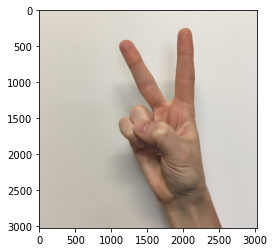

In [21]:
import imageio

img_path = 'images/my_image.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)
my_image = imageio.imread(img_path)
imshow(my_image)
print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
print(model.predict(x))

In [22]:
print(np.argmax(model.predict(x)))

0


In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

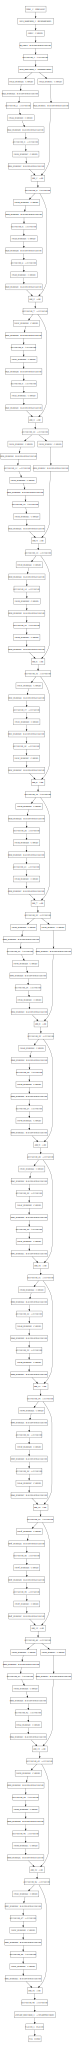

In [12]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

<font color='blue'>
    
**What you should remember:**
- Very deep "plain" networks don't work in practice because they are hard to train due to vanishing gradients.  
- The skip-connections help to address the Vanishing Gradient problem. They also make it easy for a ResNet block to learn an identity function. 
- There are two main type of blocks: The identity block and the convolutional block. 
- Very deep Residual Networks are built by stacking these blocks together.
    
### References 

This notebook presents the ResNet algorithm due to He et al. (2015). The implementation here also took significant inspiration and follows the structure given in the github repository of Francois Chollet: 

- Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun - [Deep Residual Learning for Image Recognition (2015)](https://arxiv.org/abs/1512.03385)
- Francois Chollet's github repository: https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py
